In [1]:
from tqdm import tqdm
import os
from glob import glob

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = "annotated_data"

def to_keep(ID):
    first = ID[0] in {"A", "T"}
    try:
        int(ID[1])
        return first
    except ValueError:
        return False

def parse_middle(row):
    if row.name[1].startswith("T"):
        ent_type, span = row.middle.split(" ", 1)
        return {"entity_type": ent_type, "span": span}
    else:
        keys = ["attr_type", "attr_ref", "attr_val"]
        return dict(zip(keys, str(row.middle).split()))

def df_from_ann_file(f):
    df = pd.read_csv(f, sep="\t", header=None, 
                         names=["ID", "middle", "entity_name"])
    df = df[df.ID.apply(to_keep)]
    df["file"] = f
    df = df.set_index(["file", "ID"])
    mdf = pd.DataFrame.from_records(df.apply(parse_middle, axis="columns")).set_index(df.index)

    return df.join(mdf).drop("middle", axis=1)
    return pd.concat([df, mdf], axis=1)


In [3]:
done = set()

dfs = []
pbar = tqdm(set(glob(f"{data_dir}/*/*.ann")))
for f in pbar:
    pbar.set_description(f)
    file = f.split("/")[-1]
    if file in done:
        continue
    done.add(file)    
    df = df_from_ann_file(f)
    
    dfs.append(df)

annotated_data/D/NL-HaNA_1.04.02_6853_0097.ann: 100%|█| 2199/2199 [00:18<00:00, 


In [5]:
big = pd.concat(dfs)

In [6]:
def barplot(x, y, rotation=0):
    plt.figure(figsize=(8, 8))
    plt.bar(x, y)
    # plt.plot(x, y, ".", )
    for cur_x, cur_y in zip(x, y): plt.annotate(round(cur_y, 3), (cur_x, cur_y+0.01))
    _ = plt.xticks(x, y.index, rotation=rotation)
    plt.ylim((0, 1))
    plt.show()

In [7]:
print(f"1. # unique pages annotated:\t{len(done)}")

1. # unique pages annotated:	2139


In [8]:
print(f"3.1 # of annotations (= # rows in table):\t{big.shape[0]}")
n = big[big.index.get_level_values(1).str.startswith("T")].shape[0]
print(f"3.1 # of entity annotations (= # rows in table starting with 'T'):\t{n}")
print(f"3.1 # of attribute annotations\t{big.shape[0] - n}")

3.1 # of annotations (= # rows in table):	68451
3.1 # of entity annotations (= # rows in table starting with 'T'):	32204
3.1 # of attribute annotations	36247


In [9]:
# print(f"# spans:\t{(~big.span.isna()).sum()}")

print(f"3.2 # tokens(!) in entity names:\t{big.entity_name.fillna('').str.split().apply(len).sum()}")

3.2 # tokens(!) in entity names:	79771



3.3 NUMBER OF ENTITIES PER TYPE
entity_type
Organization     1080
Person          11722
Place            4506
ProperName      14896
dtype: int64

3.3 PERCENTAGE OF ENTITIES OF TYPE
entity_type
Organization    0.033536
Person          0.363992
Place           0.139921
ProperName      0.462551
dtype: float64


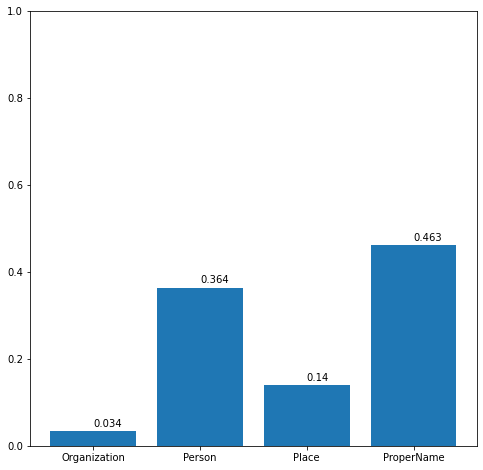


3.4 NUMBER OF TOKENS PER ENTITY TYPE
entity_type
Organization     4636
Person          32619
Place           10145
ProperName      32371
dtype: int64

3.4 AVERAGE NUMBER OF TOKENS OF EACH ENTITY PER ENTITY TYPE
entity_type
Organization    4.292593
Person          2.782716
Place           2.251443
ProperName      2.173134
dtype: float64


In [10]:
ns = big.groupby("entity_type").apply(lambda sub: (~sub.span.isna()).sum())

print("\n3.3 number of entities per type".upper())
print(ns)
print()
# print(big.groupby("entity_type").apply(lambda sub: (~sub.span.isna()).sum())/sub.shape[0])
print("3.3 percentage of entities of type".upper())
print((ns/ns.sum()))

# x, y = [1,2,3, 4], (ns/ns.sum())
# plt.figure(figsize=(8, 8))
# plt.bar(x, y)
# # plt.plot(x, y, ".", )
# for cur_x, cur_y in zip(x, y): plt.annotate(round(cur_y, 3), (cur_x, cur_y+0.01))
# _ = plt.xticks(x, y.index)
# plt.ylim((0, 1))
# plt.show()

barplot([1,2,3, 4], (ns/ns.sum()))



ns_toks = big.groupby("entity_type").apply(lambda sub:
                                     sub.entity_name.fillna('').str.split().apply(len).sum())

print("\n3.4 number of tokens per entity type".upper())
print(ns_toks)
print("\n3.4 average number of tokens of each entity per entity type".upper())
print(ns_toks/ns)

4. BENEFICIARY
No     918
Yes    163
Name: attr_val, dtype: int64

No     0.849214
Yes    0.150786
Name: attr_val, dtype: float64


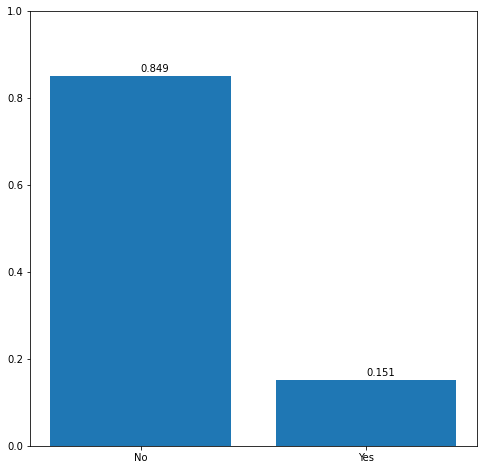


4. GENDER
Unspecified    5768
Man            4298
Woman          1234
Group           422
Name: attr_val, dtype: int64

Unspecified    0.492066
Man            0.366661
Woman          0.105272
Group          0.036001
Name: attr_val, dtype: float64


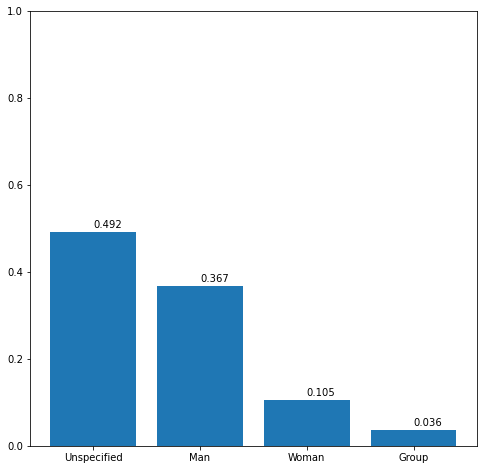


4. LEGALSTATUS
Unspecified    10680
Enslaved         887
Freed            155
Name: attr_val, dtype: int64

Unspecified    0.911107
Enslaved       0.075670
Freed          0.013223
Name: attr_val, dtype: float64


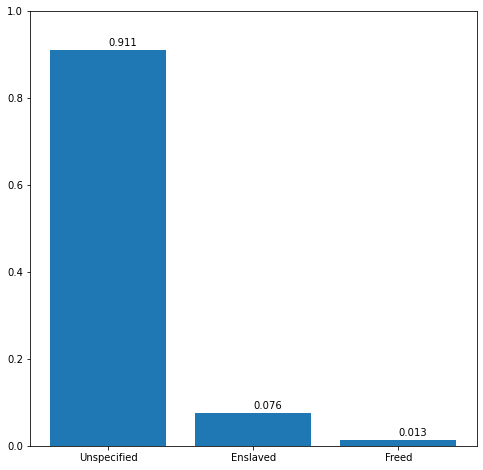


4. ROLE
Other                   5939
Beneficiary             1827
Testator                1289
Witness                 1117
Acting_Notary            801
Notary                   473
Testator_Beneficiary     276
Name: attr_val, dtype: int64

Other                   0.506654
Beneficiary             0.155861
Testator                0.109964
Witness                 0.095291
Acting_Notary           0.068333
Notary                  0.040351
Testator_Beneficiary    0.023545
Name: attr_val, dtype: float64


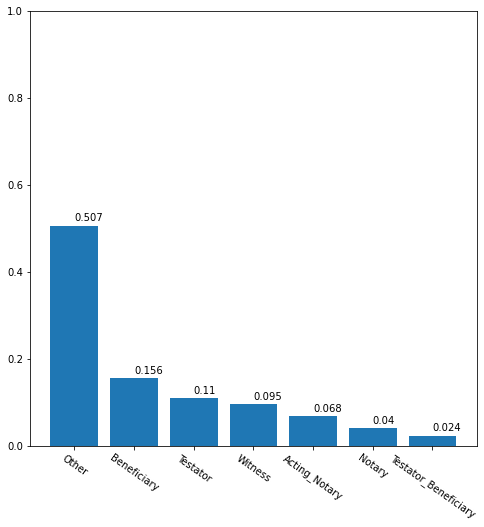

In [12]:
for at, sub in big.groupby("attr_type"):
    print(f"4. {at.upper()}")
    cs = sub.attr_val.value_counts()
    print(cs)
    print()
    print(cs/cs.sum())
    
    barplot(list(range(1, cs.shape[0]+1)),
           cs/cs.sum(), rotation=(360-35 if cs.shape[0] > 6 else 0))
    
    print()
#     sub.attr_val.hist(bins=20)
#     plt.title(at)
#     plt.show()


# big[big.attr_type == "Role"].attr_val.value_counts()